In [1]:
%matplotlib notebook
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import numpy.linalg as la
from sklearn import datasets
from sklearn.metrics import pairwise
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

In [2]:
# config
affinity = 'knn' # 'rbf' or 'knn'
normed = False # normalize laplacian
binarize = False # binarize the affinity matrix
n_neighs = 40
gamma = 20
dataset = 'moons' # 'moons' or 'uniform'

## First generate the dataset

In [3]:
n_samples = 1500
if dataset == 'moons':
    noise = 0.05
    X, Y = datasets.make_moons(n_samples=n_samples, noise=noise)
elif dataset == 'uniform':
    X, Y = np.random.rand(n_samples, 2), None

<IPython.core.display.Javascript object>


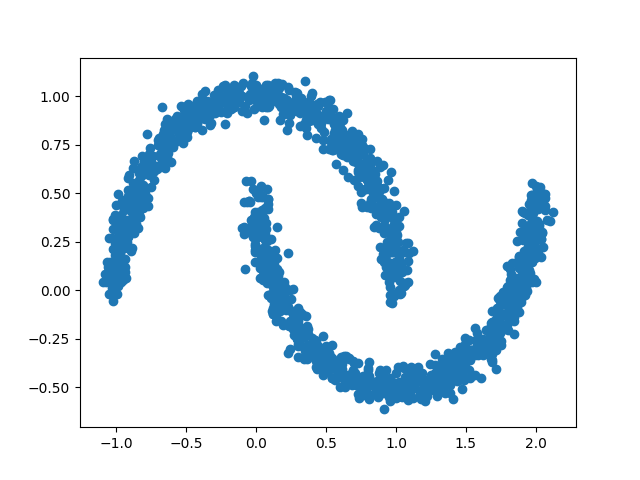

In [4]:
plt.scatter(X[:, 0], X[:, 1])

## First let's try Kmeans

<IPython.core.display.Javascript object>


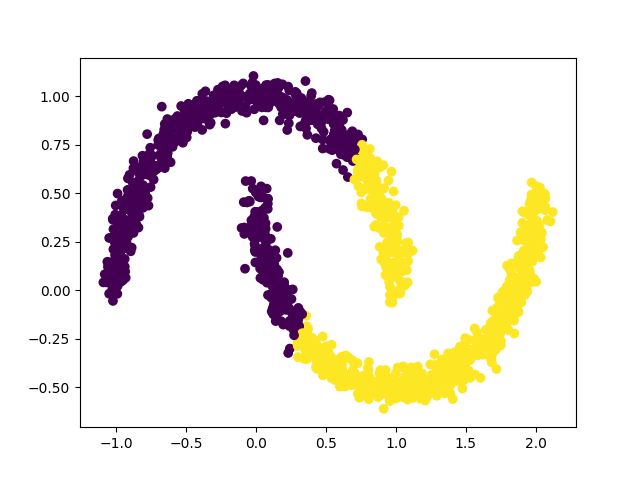

In [5]:
y_pred = KMeans(n_clusters=2, random_state=0).fit_predict(X)
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

## Compute Affinity matrix between the data points using an RBF Kernel or KNN

In [6]:
def compute_affinity(X: np.ndarray, method: str='rbf', gamma: float=1,
                    n_neighs: int=40):
    if method == 'rbf':
        aff = pairwise.rbf_kernel(X, X, gamma=gamma)
        if binarize:
            aff = (aff > 0.5).astype(aff.dtype)
    elif method == 'knn':
        res = NearestNeighbors(n_neighbors=n_neighs).fit(X)
        adj = res.kneighbors_graph(X=X, mode='connectivity')
        aff = 0.5 * (adj + adj.T)
        if binarize:
            aff = (aff > 0.0).astype(aff.dtype)
   
    return aff

K = compute_affinity(X, method=affinity, gamma=gamma, n_neighs=n_neighs)

<IPython.core.display.Javascript object>


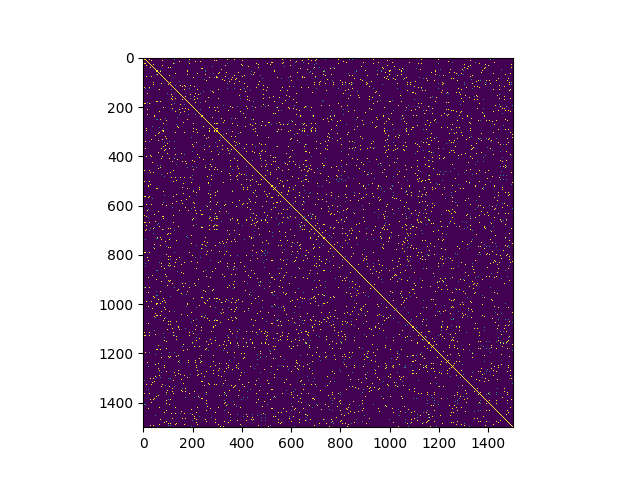

In [7]:
plt.figure()
if sp.issparse(K):
    mat = np.array(K.todense())
else:
    mat = K
plt.imshow(mat)
plt.show()

## Compute the Degree Matrix and the (normalized) Laplacian

In [8]:
L_sc, D_sc = sp.csgraph.laplacian(K, return_diag=True, normed=normed)
if sp.issparse(L_sc):
    L_sc = np.array(L_sc.todense())

In [9]:
assert np.allclose(L_sc, L_sc.T, rtol=1e-5, atol=1e-8)
evals, evectors = la.eigh(L_sc) # Matrix should be symmetric, so use `eigh`, not `eig`

-0.03651483716701473
2.0263738603754078e-16
-0.03651483716701405
4.996003610813204e-16
(1500, 12)


<IPython.core.display.Javascript object>


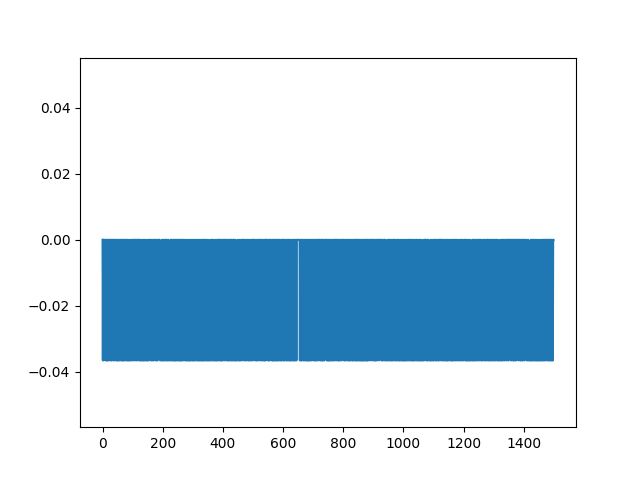

(-0.05677841896853078, 0.05522466765106112)

In [10]:
print(evectors[:, 0].min())
print(evectors[:, 0].max())
print(evectors[:, 1].min())
print(evectors[:, 1].max())

feats = evectors[:, :12] # get top-k eigenvalues, corresponding to smallest eigenvalues
print(feats.shape)

vmin = feats.min()
vmax = feats.max()

plt.figure()
plt.plot(np.arange(evectors[:, 0].shape[0]), evectors[:, 0])
plt.ylim(vmin, vmax)

## Interesting properties

The number of 0 eigenvalues is equal to the number of connected components.

The first eigenvector approximates a min cut to divide the graph into two components.

The i-th eigenvalue tells us how close is that eigenvector to split the graph into i components.

(1500, 12)


<IPython.core.display.Javascript object>


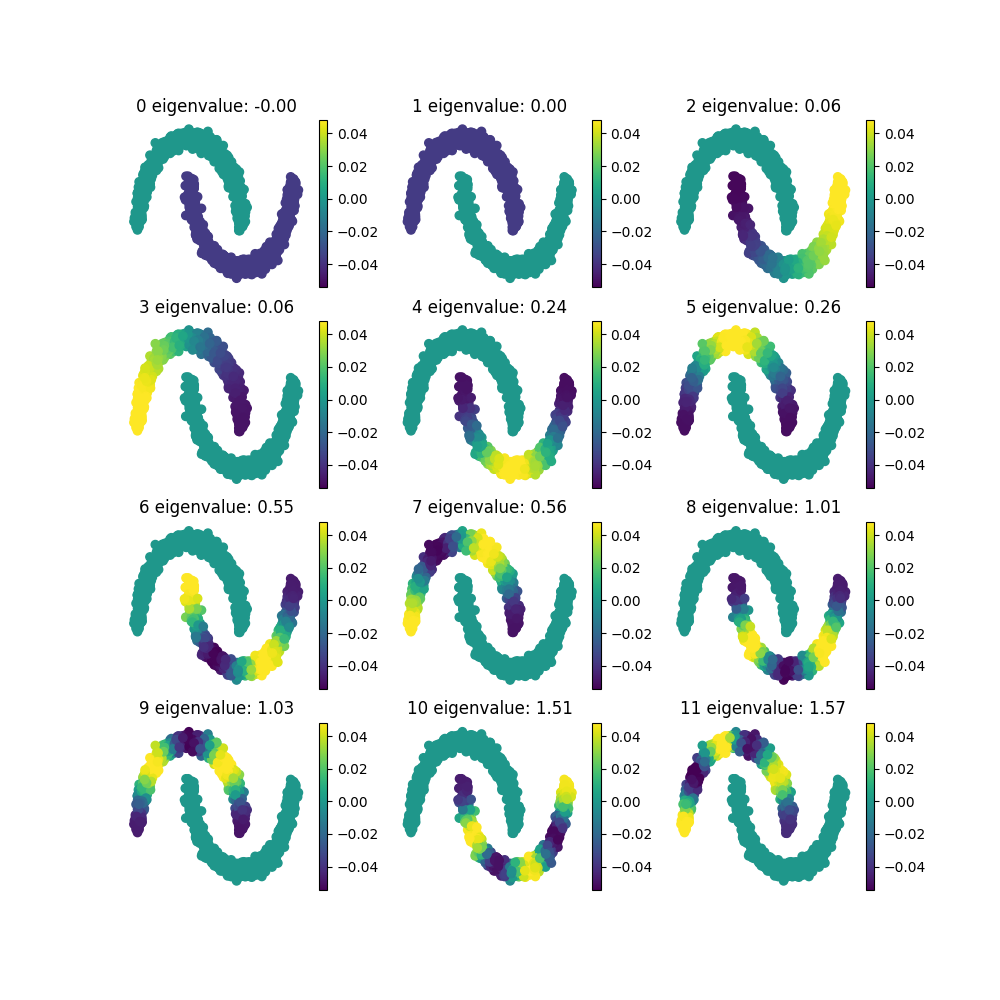

In [11]:
feats = evectors[:, :12] # get top-k eigenvalues, corresponding to smallest eigenvalues
print(feats.shape)

mean = feats.mean()
std = feats.std()
#vmin = feats.min()
vmin = mean - 2*std
#vmax = feats.max()
vmax = mean + 2*std

# plot eigenvectors:
fig, axs = plt.subplots(4, 3, figsize=(10,10))
for i in range(feats.shape[1]):
    row = i // 3
    col = i % 3
    sc = axs[row, col].scatter(X[:, 0], X[:, 1], c=feats[:, i], vmin=vmin, vmax=vmax)
    axs[row, col].set_title(f'{i} eigenvalue: {evals[i]:.2f}')
    axs[row, col].axis('off')
    plt.colorbar(sc, ax=axs[row, col])

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

<IPython.core.display.Javascript object>


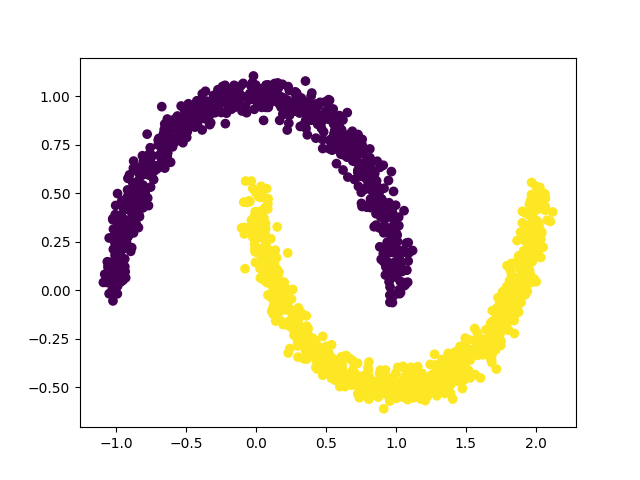

In [12]:
# my clustering
y_pred = KMeans(n_clusters=2, random_state=0).fit_predict(feats[:, 1:2])
# y_pred = feats[:, 1] > 0
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

/Users/guillemcucurull/miniconda3/envs/default/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


<IPython.core.display.Javascript object>


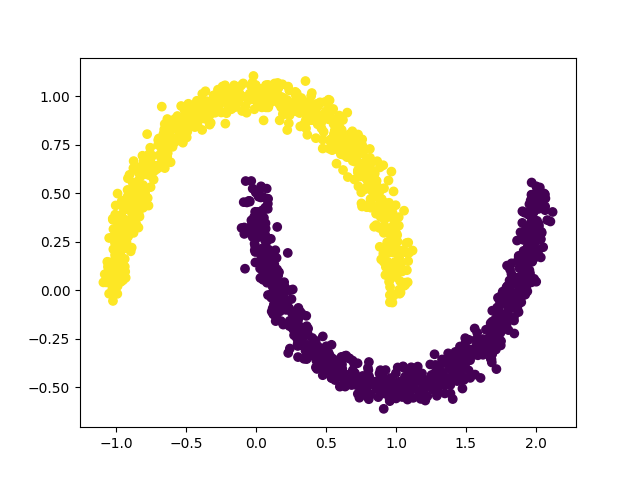

In [13]:
# with sklearn
from sklearn.cluster import SpectralClustering
SC = SpectralClustering(n_clusters=2, random_state=0, affinity='nearest_neighbors').fit(X)
y_pred = SC.labels_
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y_pred)